In [1]:
import numpy as np
import sys
import trimesh
import tetgen 
import meshio 
import math

import matplotlib.pyplot as plt
import pymeshfix as pfix
import pyvista as pv
import iso2mesh as i2m
import pygalmesh as pygm
import pymeshlab as ml

from skimage.filters import threshold_otsu
from tqdm.notebook import tqdm
from skimage.transform import resize
from typing import Any, Dict, Optional, Tuple, List

sys.path.append('./src')  # to import alveoRVE from parent directory

from alveoRVE.plot.mpl import show_four_panel_volume
from alveoRVE.plot.pv import view_surface

%load_ext autoreload
%autoreload 2

In [2]:
def matlab_to_python_conv(no, fc): 
    no_out = no[:, :3].copy()
    fc_out = (np.atleast_2d(fc).astype(np.int64)[:, :3] - 1).astype(np.int32)
    return no_out, fc_out

In [3]:
def _triangle_quality(V, F):
    # 2*sqrt(3)*A / sum(l^2)  -> 1 for equilateral; 0 for degenerate
    p0, p1, p2 = V[F[:,0]], V[F[:,1]], V[F[:,2]]
    e0 = np.linalg.norm(p1 - p0, axis=1)
    e1 = np.linalg.norm(p2 - p1, axis=1)
    e2 = np.linalg.norm(p0 - p2, axis=1)
    A  = 0.5*np.linalg.norm(np.cross(p1 - p0, p2 - p0), axis=1)
    denom = e0**2 + e1**2 + e2**2
    with np.errstate(divide='ignore', invalid='ignore'):
        q = (2.0*math.sqrt(3.0))*A/denom
        q[~np.isfinite(q)] = 0.0
    return np.clip(q, 0.0, 1.0)


def mesh_report(mesh: trimesh.Trimesh, name="mesh", plot=True, tol_dup=1e-12) -> dict:
    """
    Print thorough stats and return a dict. Does NOT mutate the mesh.
    """
    m = mesh.copy()

    print(f"\n=== {name}: geometric/graph checks START ===")
    print(f"trimesh metrics:")
    print(f"mesh is_winding_consistent? {m.is_winding_consistent}")
    print(f"mesh is_watertight? {m.is_watertight}")
    print(f"verts={len(m.vertices):,}, faces={len(m.faces):,}")
    bbox = m.bounds
    L = bbox[1] - bbox[0]
    print(f"bbox min={bbox[0]}, max={bbox[1]}, extents={L}")

    # basic areas/volumes
    A = float(m.area)
    Vvol = float(m.volume) if m.is_watertight else None
    print(f"surface area = {A:.6g}")
    if Vvol is not None:
        print(f"enclosed volume (watertight) = {Vvol:.6g}")
    else:
        print("enclosed volume = N/A (mesh not watertight)")

    # edge-length stats (proxy for 'h')
    edges = m.edges_unique
    elen  = np.linalg.norm(m.vertices[edges[:,0]] - m.vertices[edges[:,1]], axis=1)
    print(f"h (edge length): min={elen.min():.4g}, mean={elen.mean():.4g}, max={elen.max():.4g}")

    # duplicates (faces & vertices)
    F_sorted = np.sort(m.faces, axis=1)
    _, idx = np.unique(F_sorted, axis=0, return_index=True)
    dup_faces = len(m.faces) - len(idx)
    Vkey = np.round(m.vertices / tol_dup).astype(np.int64)
    _, vidx = np.unique(Vkey, axis=0, return_index=True)
    dup_verts = len(m.vertices) - len(vidx)
    print(f"duplicate faces: {dup_faces:,}, duplicate vertices (<= {tol_dup:g}): {dup_verts:,}")

    V, F = m.vertices.copy(), m.faces.copy()

    print(f"== pymeshlab metrics:")

    ms = ml.MeshSet()
    ms.add_mesh(ml.Mesh(V, F))

    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()
    print("Geometric measures:")
    for k, v in geo_measures.items():
        if k in ['surface_area', 'avg_edge_length', 'volume']:
            v = float(v)
            print(f"  {k}: {v}")
    print("Topological measures:")
    for k, v in topo_measures.items():
        if k in ['non_two_manifold_edges', 'boundary_edges', 'non_two_manifold_vertices', 'genus', 'faces_number', 'vertices_number', 'edges_number', 'connected_components_number']:
            v = int(v)
            print(f"  {k}: {v}")
    print(f"== custom metrics:")
    # triangle quality
    q = _triangle_quality(m.vertices, m.faces)
    q_stats = dict(min=float(q.min()), p5=float(np.percentile(q,5)),
                   mean=float(q.mean()), p95=float(np.percentile(q,95)),
                   max=float(q.max()))
    print(f"triangle quality q in [0,1] (equilateral=1): "
          f"min={q_stats['min']:.3f}, p5={q_stats['p5']:.3f}, "
          f"mean={q_stats['mean']:.3f}, p95={q_stats['p95']:.3f}, max={q_stats['max']:.3f}")


    if plot:
        plt.figure(figsize=(5,3))
        plt.hist(q, bins=40, range=(0,1), alpha=0.8)
        plt.xlabel("triangle quality q"); plt.ylabel("count"); plt.title(f"Quality histogram: {name}")
        plt.tight_layout(); plt.show()

    return dict(
        verts=len(m.vertices), faces=len(m.faces),
        area=A, volume=Vvol, bbox=bbox, h_stats=(float(elen.min()), float(elen.mean()), float(elen.max())),
        watertight=bool(m.is_watertight),
        dup_faces=int(dup_faces), dup_verts=int(dup_verts),
        tri_quality=q_stats
    )

def quick_mesh_report(ms: ml.MeshSet | trimesh.Trimesh, i: int = 0):
    # print(f"\n == pymeshlab quick metrics:")
    # number of vertices and faces

    flag = False
    if isinstance(ms, trimesh.Trimesh):
        flag = True
        V, F = ms.vertices, ms.faces
        ms = ml.MeshSet()
        ms.add_mesh(ml.Mesh(V, F))
    else: 
        V = ms.current_mesh().vertex_matrix()
        F = ms.current_mesh().face_matrix()

    n_verts = ms.current_mesh().vertex_number()
    n_faces = ms.current_mesh().face_number()
    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()
    h = geo_measures['avg_edge_length']

    connected_components = topo_measures['connected_components_number']

    # trimesh watertightness
    trimesh_mesh = trimesh.Trimesh(
        vertices=np.asarray(ms.current_mesh().vertex_matrix(), float),
        faces=np.asarray(ms.current_mesh().face_matrix(), int),
        process=False
    )
    is_watertight = trimesh_mesh.is_watertight
    is_winding_consistent = trimesh_mesh.is_winding_consistent

    # trimesh volume
    vol = trimesh_mesh.volume if is_watertight else None
    area = trimesh_mesh.area

    # pymeshlab nonmanifold edges/faces
    n_nonmanifold_edges = int(topo_measures['non_two_manifold_edges'])
    n_nonmanifold_vertices = int(topo_measures['non_two_manifold_vertices'])

    print(f"[quick {i} 1/3] {n_verts} verts, {n_faces} faces, watertight: {is_watertight}, genus: {topo_measures['genus']}, wind-consistent: {is_winding_consistent}, h = {np.round(h, 3)}, components: {connected_components}\n[quick {i} 2/3] vol = {vol}, area = {area}, non-manifold edges: {n_nonmanifold_edges}/ vertices: {n_nonmanifold_vertices}\n[quick {i} 3/3] bbox: {V.min(axis=0)} to {V.max(axis=0)}")

    if flag: 
        del ms

In [4]:
def heal(ms: ml.MeshSet, manifold_method = 0):
    i = 0
    print("[REMOVING DUPLICATE VERTICES]")
    ms.meshing_remove_duplicate_vertices()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING DUPLICATE FACES]")
    ms.meshing_remove_duplicate_faces()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING NULL FACES]")
    ms.meshing_remove_null_faces()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING UNREFERENCED VERTICES]")
    ms.meshing_remove_unreferenced_vertices()
    i+1; quick_mesh_report(ms, i)
    print(f"[REPAIRING NON-MANIFOLD EDGES with manifold_method = {manifold_method}]")
    ms.meshing_repair_non_manifold_edges(method=manifold_method)
    i+1; quick_mesh_report(ms, i)
    print("[REPAIRING NON-MANIFOLD VERTICES]")
    ms.meshing_repair_non_manifold_vertices()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING NULL FACES AGAIN]")
    ms.meshing_remove_null_faces()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING UNREFERENCED VERTICES AGAIN]")
    ms.meshing_remove_unreferenced_vertices()
    i+1; quick_mesh_report(ms, i)
    print(f"[REPAIRING NON-MANIFOLD EDGES AGAINx2 with manifold_method = {1-manifold_method}]")
    ms.meshing_repair_non_manifold_edges(method=1-manifold_method)
    i+1; quick_mesh_report(ms, i)
    print("[REPAIRING NON-MANIFOLD VERTICES AGAINx2]")
    ms.meshing_repair_non_manifold_vertices()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING NULL FACES AGAINx2]")
    ms.meshing_remove_null_faces()
    i+1; quick_mesh_report(ms, i)
    print("[REMOVING UNREFERENCED VERTICES AGAINx2]")
    ms.meshing_remove_unreferenced_vertices()
    i+1; quick_mesh_report(ms, i)
    geo_measures = ms.get_geometric_measures()
    topo_measures = ms.get_topological_measures()

    if trimesh.Trimesh(
        vertices=np.asarray(ms.current_mesh().vertex_matrix(), float),
        faces=np.asarray(ms.current_mesh().face_matrix(), int),
        process=False
    ).volume < 0:
        ms.meshing_invert_face_orientation()

    
    # print("\nGeometric measures:")
    # for k, v in geo_measures.items():
    #     print(f"  {k}: {v}")
    # print("\nTopological measures:")
    # for k, v in topo_measures.items():
    #     print(f"  {k}: {v}")

def remove_close_verts(ms: ml.MeshSet, tol=1e-5):
    print(f"Removing close vertices with tol={tol}")
    initial_v = ms.current_mesh().vertex_number()
    ms.meshing_merge_close_vertices(threshold = ml.PercentageValue(tol*100))
    final_v = ms.current_mesh().vertex_number()
    print(f" - removed {initial_v - final_v} vertices")

In [5]:
def print_python_or_matlab_indexing(fc, name=""): 
    if np.min(fc) == 0:
        print(f" - {name} (python)")
    elif np.min(fc) == 1:
        print(f" - {name} (matlab)")
    else:
        print(f" - {name} (unknown indexing)")

def normalize_vertices_inplace(no):
    no[:, :3] = (no[:, :3] - no[:, :3].min(axis=0)) / (no[:, :3].max(axis=0) - no[:, :3].min(axis=0))

def normalize_vertices(no): 
    no_out = no.copy()
    no_out[:, :3] = (no_out[:, :3] - no_out[:, :3].min(axis=0)) / (no_out[:, :3].max(axis=0) - no_out[:, :3].min(axis=0))
    return no_out

def view_wireframe(V: np.ndarray, F: np.ndarray, title="surface"):
    faces = np.hstack([np.full((len(F),1),3), F]).ravel()
    mesh = pv.PolyData(V, faces)
    p = pv.Plotter()
    p.add_mesh(mesh, show_edges=True, color='black', style='wireframe')
    p.add_axes(); p.show(title=title)

def view_cropped(V, F, title, point_on_plane=None, normal=None, mode="wireframe"):
    # default is half the model
    if point_on_plane is None:
        point_on_plane = V.mean(axis=1)
    if normal is None:
        normal = np.array([0,0,1])
    faces = np.hstack([np.full((len(F),1),3), F]).ravel()
    mesh = pv.PolyData(V, faces)
    clipped = mesh.clip(normal=normal, origin=point_on_plane, invert=False)
    p = pv.Plotter()
    p.add_mesh(clipped, show_edges=True, style="wireframe" if mode=="wireframe" else "surface")
    p.add_axes(); p.show(title=title)

In [6]:
mesh = meshio.read('./output_after_dedup.stl')
nodes = mesh.points
cells_dict = mesh.cells_dict
print(f"cells_dict: {cells_dict}")
elems = mesh.cells_dict['triangle']
print(nodes.shape)
print(elems.shape)

# quick report
m = trimesh.Trimesh(nodes, elems)
ms = ml.MeshSet()
ms.add_mesh(ml.Mesh(nodes, elems))
print("[ORIGINAL]")
quick_mesh_report(ms, i=0)
print_python_or_matlab_indexing(elems, "elems")

# ppymeshfix cleaning
print("[PYMESHFIX CLEANING]")
clean_nodes, clean_elems = pfix.clean_from_arrays(nodes, elems)
m = trimesh.Trimesh(clean_nodes, clean_elems)
quick_mesh_report(m, i=1)
print_python_or_matlab_indexing(clean_elems, "clean_elems")

# reorient and heal (see if needed)
ms = ml.MeshSet()
ms.add_mesh(ml.Mesh(clean_nodes, clean_elems))
ms.meshing_invert_face_orientation()
quick_mesh_report(ms, i=0)
heal(ms)

# smoothing
print(f"[SMOOTHING]")
trimesh_mesh = trimesh.Trimesh(ms.current_mesh().vertex_matrix(), ms.current_mesh().face_matrix())
smoothed_mesh = trimesh.smoothing.filter_mut_dif_laplacian(trimesh_mesh, lamb=0.5, iterations=10)
quick_mesh_report(smoothed_mesh, i=0)

# pymeshfix cleaning again
print(f"[PYMESHFIX CLEANING AGAIN]")
clean_nodes2, clean_elems2 = pfix.clean_from_arrays(smoothed_mesh.vertices, smoothed_mesh.faces)
ms0 = ml.MeshSet()
ms0.add_mesh(ml.Mesh(clean_nodes2, clean_elems2))
quick_mesh_report(ms0, i=0)
del ms0
print_python_or_matlab_indexing(clean_elems2, "clean_elems2")

# normalize nodes 
print(f"[NORMALIZING]")
normalize_vertices_inplace(clean_nodes2)
ms0 = ml.MeshSet()
ms0.add_mesh(ml.Mesh(clean_nodes2, clean_elems2))
quick_mesh_report(ms0, i=0)

/home/bnherrerac/miniconda3/envs/fenicsx-env/lib/python3.11/site-packages/meshio/stl/_stl.py:40: RuntimeWarning: overflow encountered in scalar multiply
  if 84 + num_triangles * 50 == filesize_bytes:


cells_dict: {'triangle': array([[    0,     1,     2],
       [    0,     1,     3],
       [    0,     2,     4],
       ...,
       [20933, 20940, 20941],
       [20938, 20939, 20941],
       [20940, 20939, 20941]], shape=(42148, 3))}
(20942, 3)
(42148, 3)
[ORIGINAL]
[quick 0 1/3] 20942 verts, 42148 faces, watertight: False, genus: -1, wind-consistent: False, h = 2.376, components: 1
[quick 0 2/3] vol = None, area = 100737.62110205035, non-manifold edges: 42/ vertices: 16
[quick 0 3/3] bbox: [0.4517685 1.220402  1.043662 ] to [119.5494 118.5964 118.2428]
 - elems (python)
[PYMESHFIX CLEANING]
[quick 1 1/3] 20659 verts, 41446 faces, watertight: True, genus: 33, wind-consistent: True, h = 2.398, components: 1
[quick 1 2/3] vol = -360689.6017080525, area = 100465.15105796003, non-manifold edges: 0/ vertices: 0
[quick 1 3/3] bbox: [0.45176801 1.220402   1.04366195] to [119.54940033 118.5963974  118.24279785]
 - clean_elems (python)
[quick 0 1/3] 20659 verts, 41446 faces, watertight: True

In [7]:
d = 0.01

x_plane_min_normal = (1,0,0)
x_plane_min_point = (d,0,0)
x_plane_max_normal = (-1,0,0)
x_plane_max_point = (1-d,0,0)

y_plane_min_normal = (0,1,0)
y_plane_min_point = (0,d,0)
y_plane_max_normal = (0,-1,0)
y_plane_max_point = (0,1-d,0)   

z_plane_min_normal = (0,0,1)
z_plane_min_point = (0,0,d)
z_plane_max_normal = (0,0,-1)
z_plane_max_point = (0,0,1-d)

normalized_mesh = trimesh.Trimesh(clean_nodes2, clean_elems2)

engine = "triangle" # "triangle" # "manifold", "earcut"

# consecutive slicing and capping
normalized_mesh_sliced_x_min = normalized_mesh.slice_plane(x_plane_min_point, x_plane_min_normal, cap=True, engine=engine)
print(f"new vertices after x min slice: {normalized_mesh_sliced_x_min.vertices.shape}")
normalized_mesh_sliced_x_max = normalized_mesh_sliced_x_min.slice_plane(x_plane_max_point, x_plane_max_normal, cap=True, engine=engine)
print(f"new vertices after x max slice: {normalized_mesh_sliced_x_max.vertices.shape}")
normalized_mesh_sliced_y_min = normalized_mesh_sliced_x_max.slice_plane(y_plane_min_point, y_plane_min_normal, cap=True, engine=engine)
print(f"new vertices after y min slice: {normalized_mesh_sliced_y_min.vertices.shape}")
normalized_mesh_sliced_y_max = normalized_mesh_sliced_y_min.slice_plane(y_plane_max_point, y_plane_max_normal, cap=True, engine=engine)
print(f"new vertices after y max slice: {normalized_mesh_sliced_y_max.vertices.shape}")
normalized_mesh_sliced_z_min = normalized_mesh_sliced_y_max.slice_plane(z_plane_min_point, z_plane_min_normal, cap=True, engine=engine)
print(f"new vertices after z min slice: {normalized_mesh_sliced_z_min.vertices.shape}")
normalized_mesh_sliced_all = normalized_mesh_sliced_z_min.slice_plane(z_plane_max_point, z_plane_max_normal, cap=True, engine=engine)
print(f"new vertices after z max slice: {normalized_mesh_sliced_all.vertices.shape}")

# normalize again
print(f"[NORMALIZING]")
normalize_vertices_inplace(normalized_mesh_sliced_all.vertices)

# mesh_report(normalized_mesh_sliced_all, name="after slicing and capping", plot=True)
ms0 = ml.MeshSet()
ms0.add_mesh(ml.Mesh(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces))
quick_mesh_report(ms0, i=0)
del ms0

# view_surface(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces, title="normalized")

# isotropic remeshing
h_cap = 0.01
iterations = 6  
ms = ml.MeshSet()
ms.add_mesh(ml.Mesh(normalized_mesh_sliced_all.vertices, normalized_mesh_sliced_all.faces))
print(f"[ISOTROPIC REMESHING to target h={h_cap}]")
ms.meshing_isotropic_explicit_remeshing(targetlen=ml.PercentageValue(h_cap*100),
                                        iterations=iterations,
                                        adaptive=False,
                                        reprojectflag=True
                                        )

heal(ms)

trimesh_remeshed_full = trimesh.Trimesh(np.asarray(ms.current_mesh().vertex_matrix()), np.asarray(ms.current_mesh().face_matrix()))

# view_surface(np.asarray(ms.current_mesh().vertex_matrix()), np.asarray(ms.current_mesh().face_matrix()), title="after remeshing")
# stats1 = mesh_report(trimesh_remeshed_full, name="after remeshing", plot=True)

triangle_args = pi
triangle_args = pi
triangle_args = pi
new vertices after x min slice: (20494, 3)
triangle_args = pi
new vertices after x max slice: (20231, 3)
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
new vertices after y min slice: (20084, 3)
triangle_args = pi
triangle_args = pi
new vertices after y max slice: (19952, 3)
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
new vertices after z min slice: (20010, 3)
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
triangle_args = pi
new vertices after z max slice: (19816, 3)
[NORMALIZING]
[quick 0 1/3] 19816 verts, 39760 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.021, components: 1
[quick 0 2/3] vol = 0.2283427691970301, area = 6.998647419141045, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [1. 1. 1.]
[ISOTROPIC REMESHING to target h=0.01]
[REMOVIN

In [8]:
from dataclasses import dataclass

@dataclass
class InterfaceMatchResult:
    axis: str
    plane_value: float
    tol: float
    quant: float
    nA_plane: int
    nB_plane: int
    n_common: int
    n_only_A: int
    n_only_B: int
    max_pos_error: float
    mean_pos_error: float
    mapping_B_to_A: dict   # key -> (iA, iB)
    unmatched_keys_A: list
    unmatched_keys_B: list

def compare_interface_nodes(
    VA: np.ndarray,
    VB: np.ndarray,
    axis: str = 'x',
    plane_value: float = 1.0,
    tol: float = 1e-9,
    quant: float | None = None,
    verbose: bool = True,
) -> InterfaceMatchResult:
    """
    Compare interface (planar) nodes of two meshes to see if they coincide.
    VA, VB : (N,3) float arrays
    axis   : interface normal axis: 'x', 'y', or 'z'
    plane_value : coordinate value of the interface plane
    tol    : absolute tolerance to decide if a vertex lies on the plane
    quant  : tangential quantization step; if None choose from min edge span heuristic
    Returns InterfaceMatchResult with stats and mapping pairs.
    """

    ax = {'x':0,'y':1,'z':2}[axis]
    oth = [i for i in range(3) if i != ax]

    # Select vertices on the plane
    IA = np.where(np.isclose(VA[:,ax], plane_value, atol=tol))[0]
    IB = np.where(np.isclose(VB[:,ax], plane_value, atol=tol))[0]

    if quant is None:
        # Heuristic quant: half of min non-zero spread of tangential coords
        spreads = []
        for o in oth:
            rngA = np.ptp(VA[IA,o]) if IA.size else 1.0
            rngB = np.ptp(VB[IB,o]) if IB.size else 1.0
            spreads.append(min(rngA, rngB))
        base = min(spreads) if spreads else 1.0
        quant = max(base * 1e-6, 1e-12)

    def key(p):
        return tuple(np.round(p[oth]/quant).astype(np.int64))

    # Build dictionaries keyed by quantized tangential coordinates
    dictA = {}
    for i in IA:
        dictA.setdefault(key(VA[i]), []).append(i)

    dictB = {}
    for j in IB:
        dictB.setdefault(key(VB[j]), []).append(j)

    keysA = set(dictA.keys())
    keysB = set(dictB.keys())
    common = keysA & keysB
    onlyA = sorted(keysA - keysB)
    onlyB = sorted(keysB - keysA)

    # Build 1-1 representative mapping using first index from each bucket
    mapping = {}
    errs = []
    for k in common:
        iA = dictA[k][0]
        iB = dictB[k][0]
        # positional error in full 3D
        err = np.linalg.norm(VA[iA] - VB[iB])
        errs.append(err)
        mapping[k] = (iA, iB)

    max_err = float(np.max(errs)) if errs else 0.0
    mean_err = float(np.mean(errs)) if errs else 0.0

    res = InterfaceMatchResult(
        axis=axis,
        plane_value=plane_value,
        tol=tol,
        quant=quant,
        nA_plane=len(IA),
        nB_plane=len(IB),
        n_common=len(common),
        n_only_A=len(onlyA),
        n_only_B=len(onlyB),
        max_pos_error=max_err,
        mean_pos_error=mean_err,
        mapping_B_to_A=mapping,
        unmatched_keys_A=onlyA,
        unmatched_keys_B=onlyB
    )

    if verbose:
        print(f"[interface check] axis={axis} plane={plane_value} tol={tol} quant={quant}")
        print(f"  on-plane counts: A={len(IA)} B={len(IB)}")
        print(f"  common keys: {len(common)}  onlyA={len(onlyA)}  onlyB={len(onlyB)}")
        print(f"  position error (A vs B matched reps): max={max_err:.3e} mean={mean_err:.3e}")
        if onlyA:
            print(f"  sample only-in-A key: {onlyA[0]}")
        if onlyB:
            print(f"  sample only-in-B key: {onlyB[0]}")
        if len(common) and max_err > 10*tol:
            print("  WARNING: large mismatch vs tol. Consider snapping.")

    return res

In [9]:
# reflect, and check interfaces

normalized_mesh_reflected = trimesh_remeshed_full.copy()
normalized_mesh_reflected.vertices[:,0] = 2 - trimesh_remeshed_full.vertices[:,0]
ms_reflected = ml.MeshSet()
ms_reflected.add_mesh(ml.Mesh(normalized_mesh_reflected.vertices, normalized_mesh_reflected
.faces))
heal(ms_reflected)
quick_mesh_report(ms_reflected, i=0)
normalized_mesh_reflected = trimesh.Trimesh(np.asarray(ms_reflected.current_mesh().vertex_matrix()), np.asarray(ms_reflected.current_mesh().face_matrix()), process=False)

[REMOVING DUPLICATE VERTICES]
[quick 0 1/3] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = -0.22825964642527471, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [1. 0. 0.] to [2. 1. 1.]
[REMOVING DUPLICATE FACES]
[quick 0 1/3] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = -0.22825964642527471, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [1. 0. 0.] to [2. 1. 1.]
[REMOVING NULL FACES]
[quick 0 1/3] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = -0.22825964642527471, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [1. 0. 0.] to [2. 1. 1.]
[REMOVING UNREFERENCED VERTICES]
[quick 0 1/3] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h

In [10]:
view_cropped(trimesh_remeshed_full.vertices, trimesh_remeshed_full.faces, title="original", point_on_plane=(0.5,0.5,0.5), normal=(1,0,0), mode="surface")
view_cropped(normalized_mesh_reflected.vertices, normalized_mesh_reflected.faces, title="reflected", point_on_plane=(0.5,0.5,0.5), normal=(1,0,0), mode="surface")

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f918023c650_0&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f91285cdb10_1&reconnect=auto" class="pyvi…

# Merge surface meshes (MATLAB to Python implementation)

In [11]:
def merge_surface_meshes(
    nodes1: np.ndarray,
    faces1: np.ndarray,
    nodes2: np.ndarray,
    faces2: np.ndarray,
    matching_pairs1: np.ndarray,
    matching_pairs2: np.ndarray,
    remove_duplicate_faces: bool = True,
    remove_degenerate_faces: bool = True,
    run_quick_report: bool = True,
):
    """
    Stitch two surface meshes along a planar interface by re‑using coincident
    interface vertices (provided as matched index arrays) and removing internal
    (interface) faces whose 3 vertices lie entirely on that interface set.

    Parameters
    ----------
    nodes1, faces1 : first mesh (V1x3, F1x3)
    nodes2, faces2 : second mesh (V2x3, F2x3)
    matching_pairs1 : (k,) int array of indices in nodes1 (0-based)
    matching_pairs2 : (k,) int array of corresponding indices in nodes2 (0-based)
    remove_duplicate_faces : remove face duplicates after merge
    remove_degenerate_faces : drop faces with repeated vertex indices
    run_quick_report : call quick_mesh_report on merged mesh (assumes it exists)

    Returns
    -------
    merged_nodes : (Vout,3) float
    merged_faces : (Fout,3) int
    map_nodes1   : (V1,) int mapping old indices -> merged indices (identity)
    map_nodes2   : (V2,) int mapping old indices -> merged indices
    info         : dict with diagnostics
    """

    # --- Basic checks ---
    if matching_pairs1.shape != matching_pairs2.shape:
        raise ValueError("matching_pairs1 and matching_pairs2 must have same shape")
    if len(np.unique(matching_pairs1)) != len(matching_pairs1):
        raise ValueError("matching_pairs1 has duplicate indices")
    if len(np.unique(matching_pairs2)) != len(matching_pairs2):
        raise ValueError("matching_pairs2 has duplicate indices")

    num_nodes1 = nodes1.shape[0]
    num_nodes2 = nodes2.shape[0]

    # --- Determine which nodes from mesh2 are unique (not matched) ---
    nodes2_to_add_mask = np.ones(num_nodes2, dtype=bool)
    nodes2_to_add_mask[matching_pairs2] = False
    nodes2_unique_to_add = nodes2[nodes2_to_add_mask]

    # --- Build merged node array (mesh1 nodes first, then unmatched mesh2 nodes) ---
    merged_nodes = np.vstack([nodes1, nodes2_unique_to_add])

    # --- Build index maps ---
    map_nodes1 = np.arange(num_nodes1, dtype=np.int64)         # identity
    map_nodes2 = np.full(num_nodes2, -1, dtype=np.int64)

    # For matched pairs: map nodes2 indices to corresponding nodes1 indices
    map_nodes2[matching_pairs2] = map_nodes1[matching_pairs1]

    # For unmatched nodes2: assign new indices sequentially
    next_idx = num_nodes1
    for j in np.where(nodes2_to_add_mask)[0]:
        map_nodes2[j] = next_idx
        next_idx += 1

    assert np.all(map_nodes2 >= 0), "Unmapped node(s) remain in mesh2."

    # --- Identify and remove internal faces (those whose 3 vertices all lie in interface sets) ---
    merged_face_list = []

    def external_faces(faces, interface_idx_set):
        if faces.size == 0:
            return faces
        # boolean mask: True if face is internal (all three vertices interface nodes)
        internal_mask = np.all(np.isin(faces, interface_idx_set), axis=1)
        return faces[~internal_mask]

    interface_set1 = set(matching_pairs1.tolist())
    interface_set2 = set(matching_pairs2.tolist())

    faces1_external = external_faces(faces1, interface_set1)
    faces2_external = external_faces(faces2, interface_set2)

    # Remap faces: faces1 via map_nodes1 (identity) ; faces2 via map_nodes2
    if faces1_external.size:
        merged_face_list.append(faces1_external.copy())
    if faces2_external.size:
        merged_face_list.append(map_nodes2[faces2_external])

    if merged_face_list:
        merged_faces = np.vstack(merged_face_list)
    else:
        merged_faces = np.zeros((0, faces1.shape[1] if faces1.size else 3), dtype=np.int64)

    # --- Optional cleanup: degenerate & duplicate faces ---
    n_before = merged_faces.shape[0]

    if remove_degenerate_faces and merged_faces.size:
        deg_mask = (merged_faces[:,0] != merged_faces[:,1]) & \
                   (merged_faces[:,0] != merged_faces[:,2]) & \
                   (merged_faces[:,1] != merged_faces[:,2])
        merged_faces = merged_faces[deg_mask]

    if remove_duplicate_faces and merged_faces.size:
        sf = np.sort(merged_faces, axis=1)
        _, keep_idx = np.unique(sf, axis=0, return_index=True)
        merged_faces = merged_faces[np.sort(keep_idx)]

    n_after = merged_faces.shape[0]

    # --- Diagnostics ---
    info = dict(
        n_nodes1=num_nodes1,
        n_nodes2=num_nodes2,
        n_match=len(matching_pairs1),
        n_added=np.count_nonzero(nodes2_to_add_mask),
        faces_initial=n_before,
        faces_final=n_after
    )

    print("[merge_surface_meshes]")
    print(f"  nodes1={num_nodes1} nodes2={num_nodes2} matched={len(matching_pairs1)} added_from_mesh2={info['n_added']}")
    print(f"  faces_before_cleanup={n_before} faces_after_cleanup={n_after}")

    # save to temporary stl
    merged_mesh = trimesh.Trimesh(merged_nodes, merged_faces, process=False)
    temp_stl_path = "/tmp/merged_mesh.stl"
    merged_mesh.export(temp_stl_path)
    print(f"[TEMP STL SAVED] {temp_stl_path}")

    # open stl via meshio and load faces and elems
    mesh = meshio.read(temp_stl_path)
    merged_nodes = mesh.points
    cells_dict = mesh.cells_dict
    print(f"cells_dict: {cells_dict}")
    merged_faces = mesh.cells_dict['triangle']
    print(merged_nodes.shape)
    print(merged_faces.shape)

    # # add pymeshfix cleaning
    # print(f"[PYMESHFIX CLEANING MERGED MESH]")
    
    ms_merged = ml.MeshSet()
    ms_merged.add_mesh(ml.Mesh(merged_nodes, merged_faces))
    # print(f"[GENERATING BY MERGING VISIBLE MESHES]")
    # ms_merged.generate_by_merging_visible_meshes(deletelayer=True, mergevertices=True, alsounreferenced=False)
    quick_mesh_report(ms_merged, i=0)
    print("[REMOVING CLOSE VERTICES]")
    remove_close_verts(ms_merged, tol=1e-5)
    quick_mesh_report(ms_merged, i=0)
    manifold_method = 1
    print(f"[HEALING MERGED MESH with manifold_method={manifold_method}]")
    heal(ms_merged, manifold_method=1)
    
    # print(f"[REMOVING NON MANIFOLD VERTICES AGAIN!]")
    # ms_merged.meshing_repair_non_manifold_vertices()
    quick_mesh_report(ms_merged, i=0)


    merged_nodes = np.asarray(ms_merged.current_mesh().vertex_matrix())
    merged_faces = np.asarray(ms_merged.current_mesh().face_matrix())

    view_wireframe(merged_nodes, merged_faces, title="merged mesh after pymeshlab")
    view_cropped(merged_nodes, merged_faces, title="merged mesh after pymeshfix", point_on_plane=(0.5,0.5,0.5), normal=(0,1,0), mode="surface")

    # merged_nodes, merged_faces = pfix.clean_from_arrays(merged_nodes, merged_faces)
    
    # --- Optional quick report ---
    if run_quick_report:
        try:
            merged_tm = trimesh.Trimesh(merged_nodes, merged_faces, process=False)
            quick_mesh_report(merged_tm, i=0)  # assumes quick_mesh_report available
        except Exception as e:
            print(f"  [quick_mesh_report skipped] {e}")

    return merged_nodes, merged_faces, map_nodes1, map_nodes2, info



In [12]:
res = compare_interface_nodes(trimesh_remeshed_full.vertices, normalized_mesh_reflected.vertices, axis='x', plane_value=1.0)
# print dictionary as columns
for k, v in res.__dict__.items():
    print(f"{k}: {v}")

[interface check] axis=x plane=1.0 tol=1e-09 quant=9.70847993725094e-07
  on-plane counts: A=1276 B=1276
  common keys: 1276  onlyA=0  onlyB=0
  position error (A vs B matched reps): max=8.584e-06 mean=8.990e-09
axis: x
plane_value: 1.0
tol: 1e-09
quant: 9.70847993725094e-07
nA_plane: 1276
nB_plane: 1276
n_common: 1276
n_only_A: 0
n_only_B: 0
max_pos_error: 8.58404026349291e-06
mean_pos_error: 8.990269940900435e-09
mapping_B_to_A: {(np.int64(1013116), np.int64(505542)): (np.int64(23939), np.int64(23939)), (np.int64(1022084), np.int64(535176)): (np.int64(11341), np.int64(11341)), (np.int64(847683), np.int64(552886)): (np.int64(21255), np.int64(21255)), (np.int64(888334), np.int64(697954)): (np.int64(24971), np.int64(24971)), (np.int64(679717), np.int64(371259)): (np.int64(25364), np.int64(25364)), (np.int64(334357), np.int64(463019)): (np.int64(23711), np.int64(23711)), (np.int64(546590), np.int64(465261)): (np.int64(24990), np.int64(24990)), (np.int64(960676), np.int64(784982)): (np.in

In [13]:
pairs = list(res.mapping_B_to_A.values())   # list of (iA, iB)
matching_pairs1 = np.array([p[0] for p in pairs], dtype=np.int64)
matching_pairs2 = np.array([p[1] for p in pairs], dtype=np.int64)

# 2. Merge:
merged_nodes, merged_faces, map1, map2, info = merge_surface_meshes(
    trimesh_remeshed_full.vertices,
    trimesh_remeshed_full.faces,
    normalized_mesh_reflected.vertices,
    normalized_mesh_reflected.faces,
    matching_pairs1,
    matching_pairs2, 
    remove_duplicate_faces=False,
    remove_degenerate_faces=False,
)

# 3. Wrap as trimesh and visualize:
merged_mesh = trimesh.Trimesh(merged_nodes, merged_faces, process=False)
mesh_report(merged_mesh, name="merged_mesh", plot=False)
view_surface(merged_mesh.vertices, merged_mesh.faces, title="stitched (X)")

[merge_surface_meshes]
  nodes1=26906 nodes2=26906 matched=1276 added_from_mesh2=25630
  faces_before_cleanup=107880 faces_after_cleanup=107880
[TEMP STL SAVED] /tmp/merged_mesh.stl
cells_dict: {'triangle': array([[    0,     1,     2],
       [    3,     4,     5],
       [    6,     3,     5],
       ...,
       [33584, 33232, 47855],
       [48013, 30463, 48014],
       [48114, 48116, 47869]], shape=(107880, 3))}
(52536, 3)
(107880, 3)
[quick 0 1/3] 52536 verts, 107880 faces, watertight: False, genus: -1, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = None, area = 13.93851406576538, non-manifold edges: 13636/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [2. 1. 1.]
[REMOVING CLOSE VERTICES]
Removing close vertices with tol=1e-05
 - removed 0 vertices
[quick 0 1/3] 52536 verts, 107880 faces, watertight: False, genus: -1, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = None, area = 13.93851406576538, non-manifold edges: 13636/ vertices: 0
[quic

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f91285cd910_2&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f9100156790_3&reconnect=auto" class="pyvi…

[quick 0 1/3] 53374 verts, 105747 faces, watertight: False, genus: 64, wind-consistent: False, h = 0.017, components: 3
[quick 0 2/3] vol = None, area = 13.669021367832757, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [2. 1. 1.]

=== merged_mesh: geometric/graph checks START ===
trimesh metrics:
mesh is_winding_consistent? False
mesh is_watertight? False
verts=53,374, faces=105,747
bbox min=[0. 0. 0.], max=[2. 1. 1.], extents=[2. 1. 1.]
surface area = 13.669
enclosed volume = N/A (mesh not watertight)
h (edge length): min=3.249e-05, mean=0.0175, max=0.03632
duplicate faces: 0, duplicate vertices (<= 1e-12): 838
== pymeshlab metrics:
Geometric measures:
  avg_edge_length: 0.01749936734598538
  surface_area: 13.669021606445312
Topological measures:
  boundary_edges: 1257
  connected_components_number: 3
  edges_number: 159249
  faces_number: 105747
  genus: 64
  non_two_manifold_edges: 0
  non_two_manifold_vertices: 0
  vertices_number: 53374
== custom metrics:
tr

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f908c6ca190_4&reconnect=auto" class="pyvi…

[PYMESHFIX CLEANING MERGED MESH AGAIN]

=== merged_mesh after pymesfix: geometric/graph checks START ===
trimesh metrics:
mesh is_winding_consistent? True
mesh is_watertight? True
verts=27,208, faces=54,540
bbox min=[0. 0. 0.], max=[1. 1. 1.], extents=[1. 1. 1.]
surface area = 6.98443
enclosed volume (watertight) = 0.228426
h (edge length): min=3.24e-05, mean=0.01744, max=0.1163
duplicate faces: 0, duplicate vertices (<= 1e-12): 0
== pymeshlab metrics:
Geometric measures:
  avg_edge_length: 0.017435531860230592
  surface_area: 6.984425067901611
Topological measures:
  boundary_edges: 0
  connected_components_number: 1
  edges_number: 81810
  faces_number: 54540
  genus: 32
  non_two_manifold_edges: 0
  non_two_manifold_vertices: 0
  vertices_number: 27208
== custom metrics:
triangle quality q in [0,1] (equilateral=1): min=0.001, p5=0.388, mean=0.467, p95=0.499, max=0.500


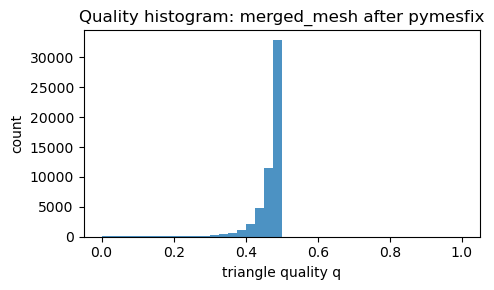

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f908c6c84d0_5&reconnect=auto" class="pyvi…

In [14]:
# pymeshfix cleaning
print(f"[PYMESHFIX CLEANING MERGED MESH AGAIN]")
clean_nodes, clean_elems = pfix.clean_from_arrays(merged_nodes, merged_faces)
m = trimesh.Trimesh(clean_nodes, clean_elems)
mesh_report(m, name="merged_mesh after pymesfix", plot=True)
view_surface(clean_nodes, clean_elems, title="stitched cleaned (X)")

In [15]:
# import tetgen 

# # tetrahedralize the mesh 
# tg = tetgen.TetGen(merged_mesh.vertices, merged_mesh.faces)
# tg.tetrahedralize(order=1, mindihedral=10, minratio=1.5, steinerleft=0, maxvolume=0.001)
# nodes_tet = tg.node
# print(f"tetgen nodes: {nodes_tet.shape}")
# elems_tet = tg.elem
# print(f"tetrahedral mesh: {nodes_tet.shape}, {elems_tet.shape}")
# print(f"min node index: {elems_tet.min()}, max node index: {elems_tet.max()}")

# # view its surface 
# surf = tg.f
# view_surface(nodes_tet, surf, title="tet mesh surface")

# # create trimesh surface and quickmeshreport
# tet_mesh = trimesh.Trimesh(nodes_tet, surf, process=False)
# mesh_report(tet_mesh, name="tet_mesh", plot=True)
# quick_mesh_report(tet_mesh, i=0)

# ms = ml.MeshSet()
# ms.add_mesh(ml.Mesh(tet_mesh.vertices, tet_mesh.faces))
# heal(ms)


# # additional filters, 
# tg = tetgen.TetGen(np.asarray(ms.current_mesh().vertex_matrix()), np.asarray(ms.current_mesh().face_matrix()))
# tg.tetrahedralize(order=1, mindihedral=10, minratio=1.5, steinerleft=0, maxvolume=0.001)
# nodes_tet_clean = tg.node
# print(f"tetgen nodes after heal: {nodes_tet_clean.shape}")
# elems_tet_clean = tg.elem
# print(f"tetrahedral mesh after heal: {nodes_tet_clean.shape}, {elems_tet_clean.shape}")
# print(f"min node index: {elems_tet_clean.min()}, max node index: {elems_tet_clean.max()}")

# tet_mesh_clean = trimesh.Trimesh(nodes_tet_clean, tg.f, process=False)
# mesh_report(tet_mesh_clean, name="tet_mesh_clean after heal", plot=True)
# quick_mesh_report(tet_mesh_clean, i=0)

## From 02 test, `trimesh.boolean.union`

In [16]:

quick_mesh_report(ms, i=0)

V0 = np.asarray(trimesh_remeshed_full.vertices, float)
V0 = np.stack((V0[:,0], V0[:,1], V0[:,2]), axis=-1)
F0 = np.asarray(trimesh_remeshed_full.faces,    int)

# V0 = normalize_vertices(V0)

print(f"bounding box: min={V0.min(axis=0)}, max={V0.max(axis=0)}")

shift_x = np.array([2,0,0], float)
V0x = np.stack((2 - V0[:,0], V0[:,1], V0[:,2]), axis=-1)
print(f"bounding box after shift in x: min={V0x.min(axis=0)}, max={V0x.max(axis=0)}")
assert V0.shape == V0x.shape

ms_reflected = ml.MeshSet()
ms_reflected.add_mesh(ml.Mesh(V0x, F0))
ms_reflected.meshing_invert_face_orientation()
quick_mesh_report(ms_reflected, i=0)

orig_trimesh_mesh = trimesh.Trimesh(V0, F0)
x_trimesh_mesh = trimesh.Trimesh(ms_reflected.current_mesh().vertex_matrix(), ms_reflected.current_mesh().face_matrix())
orig_x_trimesh_mesh = trimesh.boolean.union([orig_trimesh_mesh, x_trimesh_mesh])
print("fused in x direction")
# mesh_report(orig_x_trimesh_mesh, name="after fusing in x - blender", plot=True)
orig_x_ms = ml.MeshSet()
orig_x_ms.add_mesh(ml.Mesh(orig_x_trimesh_mesh.vertices, orig_x_trimesh_mesh.faces))
quick_mesh_report(orig_x_ms, i=0)
heal(orig_x_ms, manifold_method=1)
# quick_mesh_report(orig_x_ms, i=0)


print(f"bounding box after fusing in x: min={orig_x_trimesh_mesh.vertices.min(axis=0)}, max={orig_x_trimesh_mesh.vertices.max(axis=0)}")

view_surface(orig_x_ms.current_mesh().vertex_matrix(), orig_x_ms.current_mesh().face_matrix(), title="after fusing in x - remeshlab", plane=True, planepoint=[1,0.5,0.5], planenormal=[1,0,0])
view_cropped(orig_x_ms.current_mesh().vertex_matrix(), orig_x_ms.current_mesh().face_matrix(), title="after fusing in x - remeshlab cropped", point_on_plane=(0.5,0.5,0.5), normal=(0,1,0), mode="surface")
# view_surface(orig_x_trimesh_mesh.vertices, orig_x_trimesh_mesh.faces, title="after fusing in x - blender")
# view_wireframe(orig_x_trimesh_mesh.vertices, orig_x_trimesh_mesh.faces, title="after fusing in x - wireframe")

[quick 0 1/3] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = 0.22825964642527466, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [1. 1. 1.]
bounding box: min=[0. 0. 0.], max=[1. 1. 1.]
bounding box after shift in x: min=[1. 0. 0.], max=[2. 1. 1.]
[quick 0 1/3] 26906 verts, 53940 faces, watertight: True, genus: 33, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = 0.22825964642527463, area = 6.969256940601027, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [1. 0. 0.] to [2. 1. 1.]
fused in x direction
[quick 0 1/3] 51661 verts, 103578 faces, watertight: True, genus: 65, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = 0.45651929448278633, area = 13.401812042761279, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [2. 1. 1.]
[REMOVING DUPLICATE VERTICES]
[quick 0 1/3] 51661 verts, 103578 faces, waterti

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f908c0d8e90_6&reconnect=auto" class="pyvi…

A view with name (P_0x7f908c0d8e90_6) is already registered
 => returning previous one


Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f908c0d8e90_6&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f908c183d10_7&reconnect=auto" class="pyvi…

In [17]:
import tetgen 

# tetrahedralize the mesh 

VV = np.asarray(orig_x_ms.current_mesh().vertex_matrix())
FF = np.asarray(orig_x_ms.current_mesh().face_matrix())

# starting quick mesh report
print("[before tetgen]")
quick_mesh_report(orig_x_ms, i=0)

tg = tetgen.TetGen(VV, FF)
tg.tetrahedralize(order=1, mindihedral=10, minratio=1.5, steinerleft=0, maxvolume=0.001)
nodes_tet = tg.node
print(f"tetgen nodes: {nodes_tet.shape}")
elems_tet = tg.elem
print(f"tetrahedral mesh: {nodes_tet.shape}, {elems_tet.shape}")
print(f"min node index: {elems_tet.min()}, max node index: {elems_tet.max()}")

# view its surface 
surf = tg.f
view_surface(nodes_tet, surf, title="tet mesh surface")

# create trimesh surface and quickmeshreport
# tet_mesh = trimesh.Trimesh(nodes_tet, surf, process=True)
# mesh_report(tet_mesh, name="tet_mesh", plot=True)
# quick_mesh_report(tet_mesh, i=0)

# ms = ml.MeshSet()
# ms.add_mesh(ml.Mesh(tet_mesh.vertices, tet_mesh.faces))
# heal(ms)


# # additional filters, 
# tg = tetgen.TetGen(np.asarray(ms.current_mesh().vertex_matrix()), np.asarray(ms.current_mesh().face_matrix()))
# tg.tetrahedralize(order=1, mindihedral=10, minratio=1.5, steinerleft=0, maxvolume=0.001)
# nodes_tet_clean = tg.node
# print(f"tetgen nodes after heal: {nodes_tet_clean.shape}")
# elems_tet_clean = tg.elem
# print(f"tetrahedral mesh after heal: {nodes_tet_clean.shape}, {elems_tet_clean.shape}")
# print(f"min node index: {elems_tet_clean.min()}, max node index: {elems_tet_clean.max()}")

# tet_mesh_clean = trimesh.Trimesh(nodes_tet_clean, tg.f, process=False)
# mesh_report(tet_mesh_clean, name="tet_mesh_clean after heal", plot=True)
# quick_mesh_report(tet_mesh_clean, i=0)

[before tetgen]
[quick 0 1/3] 51661 verts, 103578 faces, watertight: True, genus: 65, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = 0.45651929448278633, area = 13.401812042761279, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [2. 1. 1.]
tetgen nodes: (51661, 3)
tetrahedral mesh: (51661, 3), (162594, 4)
min node index: 0, max node index: 51660


Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f908022a790_8&reconnect=auto" class="pyvi…

In [ ]:
# now in y 

V0 = np.asarray(nodes_tet, float) #np.asarray(orig_x_ms.current_mesh().vertex_matrix(), float)
F0 = np.asarray(surf) # np.asarray(orig_x_ms.current_mesh().face_matrix(), int)

# V0 = normalize_vertices(V0)

print(f"bounding box: min={V0.min(axis=0)}, max={V0.max(axis=0)}")

shift_y = np.array([0,2,0], float)
V0y = np.stack((V0[:,0], 2 - V0[:,1], V0[:,2]), axis=-1)
print(f"bounding box after shift in y: min={V0y.min(axis=0)}, max={V0y.max(axis=0)}")
assert V0.shape == V0y.shape

ms_reflected = ml.MeshSet()
ms_reflected.add_mesh(ml.Mesh(V0y, F0))
ms_reflected.meshing_invert_face_orientation()
print("[after reflecting in y]")
quick_mesh_report(ms_reflected, i=0)

orig_trimesh_mesh = trimesh.Trimesh(V0, F0)
y_trimesh_mesh = trimesh.Trimesh(ms_reflected.current_mesh().vertex_matrix(), ms_reflected.current_mesh().face_matrix())
orig_y_trimesh_mesh = trimesh.boolean.union([orig_trimesh_mesh, y_trimesh_mesh])
print("fused in y direction")
# mesh_report(orig_y_trimesh_mesh, name="after fusing in y - blender", plot=True)
orig_y_ms = ml.MeshSet()
orig_y_ms.add_mesh(ml.Mesh(orig_y_trimesh_mesh.vertices, orig_y_trimesh_mesh.faces))
quick_mesh_report(orig_y_ms, i=0)
heal(orig_y_ms, manifold_method=0)
# quick_mesh_report(orig_y_ms, i=0)
print("[REMOVING SMALL CONNECTED COMPONENTS]")
orig_y_ms.meshing_remove_connected_component_by_diameter()
quick_mesh_report(orig_y_ms, i=0)

print(f"bounding box after fusing in y: min={orig_y_trimesh_mesh.vertices.min(axis=0)}, max={orig_y_trimesh_mesh.vertices.max(axis=0)}")

view_surface(orig_y_ms.current_mesh().vertex_matrix(), orig_y_ms.current_mesh().face_matrix(), title="after fusing in y - remeshlab", plane=False, planepoint=[1,0.5,0.5], planenormal=[1,0,0])
view_cropped(orig_y_ms.current_mesh().vertex_matrix(), orig_y_ms.current_mesh().face_matrix(), title="after fusing in y - remeshlab cropped", point_on_plane=(0.5,0.5,0.5), normal=(0,0,1), mode="surface")
# view_surface(orig_y_trimesh_mesh.vertices, orig_y_trimesh_mesh.faces, title="after fusing in y - blender")
# view_wireframe(orig_y_trimesh_mesh.vertices, orig_y_trimesh_mesh.faces, title="after fusing in y - wireframe")

bounding box: min=[0. 0. 0.], max=[2. 1. 1.]
bounding box after shift in y: min=[0. 1. 0.], max=[2. 2. 1.]
[after reflecting in y]
[quick 0 1/3] 51661 verts, 103578 faces, watertight: True, genus: 65, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = 0.45651929448278633, area = 13.401812042761277, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 1. 0.] to [2. 2. 1.]
fused in y direction
[quick 0 1/3] 101049 verts, 202614 faces, watertight: True, genus: 132, wind-consistent: True, h = 0.018, components: 3
[quick 0 2/3] vol = 0.9130385893740648, area = 26.22370191377982, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [2. 2. 1.]
[REMOVING DUPLICATE VERTICES]
[quick 0 1/3] 101049 verts, 202614 faces, watertight: True, genus: 132, wind-consistent: True, h = 0.018, components: 3
[quick 0 2/3] vol = 0.9130385893740648, area = 26.22370191377982, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [2. 2. 1.]
[REMOVING DUPLICATE 

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f90281683d0_9&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:46635/index.html?ui=P_0x7f90281d8310_10&reconnect=auto" class="pyv…

: 

In [ ]:
# now in z

V0 = np.asarray(orig_y_ms.current_mesh().vertex_matrix(), float)
F0 = np.asarray(orig_y_ms.current_mesh().face_matrix(), int)

# V0 = normalize_vertices(V0)

print(f"bounding box: min={V0.min(axis=0)}, max={V0.max(axis=0)}")

shift_z = np.array([0,0,2], float)
V0z = np.stack((V0[:,0], V0[:,1], 2 - V0[:,2] - 1e-3), axis=-1)
print(f"bounding box after shift in z: min={V0z.min(axis=0)}, max={V0z.max(axis=0)}")
assert V0.shape == V0z.shape

ms_reflected = ml.MeshSet()
ms_reflected.add_mesh(ml.Mesh(V0z, F0))
ms_reflected.meshing_invert_face_orientation()
print("[after reflecting in z]")
quick_mesh_report(ms_reflected, i=0)

orig_trimesh_mesh = trimesh.Trimesh(V0, F0)
z_trimesh_mesh = trimesh.Trimesh(ms_reflected.current_mesh().vertex_matrix(), ms_reflected.current_mesh().face_matrix())
orig_z_trimesh_mesh = trimesh.boolean.union([orig_trimesh_mesh, z_trimesh_mesh])
print("fused in z direction")
# mesh_report(orig_z_trimesh_mesh, name="after fusing in z - blender", plot=True)
orig_z_ms = ml.MeshSet()
orig_z_ms.add_mesh(ml.Mesh(orig_z_trimesh_mesh.vertices, orig_z_trimesh_mesh.faces))
quick_mesh_report(orig_z_ms, i=0)
heal(orig_z_ms, manifold_method=0)
# quick_mesh_report(orig_y_ms, i=0)
print("[MESHING REPAIR NON MANIFOLD VERTICES]")
orig_z_ms.meshing_repair_non_manifold_vertices()
quick_mesh_report(orig_z_ms, i=0)

print(f"bounding box after fusing in z: min={orig_z_trimesh_mesh.vertices.min(axis=0)}, max={orig_z_trimesh_mesh.vertices.max(axis=0)}")

# view_surface(orig_z_ms.current_mesh().vertex_matrix(), orig_z_ms.current_mesh().face_matrix(), title="after fusing in z - remeshlab", plane=False, planepoint=[1,0.5,0.5], planenormal=[1,0,0])
# view_cropped(orig_z_ms.current_mesh().vertex_matrix(), orig_z_ms.current_mesh().face_matrix(), title="after fusing in z - remeshlab cropped", point_on_plane=(0.5,0.5,0.5), normal=(0,0,1), mode="surface")
# view_surface(orig_z_trimesh_mesh.vertices, orig_z_trimesh_mesh.faces, title="after fusing in z - blender")

bounding box: min=[0. 0. 0.], max=[2. 2. 1.]
bounding box after shift in z: min=[0.    0.    0.999], max=[2.    2.    1.999]
[after reflecting in z]
[quick 0 1/3] 100929 verts, 202382 faces, watertight: True, genus: 132, wind-consistent: True, h = 0.018, components: 1
[quick 0 2/3] vol = 0.9132273641332933, area = 26.196415246561024, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0.    0.    0.999] to [2.    2.    1.999]
fused in z direction
[quick 0 1/3] 200214 verts, 401532 faces, watertight: True, genus: 277, wind-consistent: True, h = 0.017, components: 1
[quick 0 2/3] vol = 1.8257260034360687, area = 50.91224601954718, non-manifold edges: 0/ vertices: 0
[quick 0 3/3] bbox: [0. 0. 0.] to [2.         2.         1.99899995]
[REMOVING DUPLICATE VERTICES]
[quick 0 1/3] 200214 verts, 401532 faces, watertight: True, genus: 277, wind-consistent: True, h = 0.017, components: 1
[quick 0 2/3] vol = 1.8257260034360687, area = 50.91224601954718, non-manifold edges: 0/ vertices: 0
[qui

In [ ]:
# save as stl
final_stl_path = "./final_stitched.stl"

import meshio 

mesh = meshio.Mesh(points=orig_z_ms.current_mesh().vertex_matrix(), cells=[("triangle", orig_z_ms.current_mesh().face_matrix())])
mesh.write(final_stl_path)

In [ ]:
# # tetrahedralize the mesh
# VV = np.asarray(orig_z_ms.current_mesh().vertex_matrix())
# FF = np.asarray(orig_z_ms.current_mesh().face_matrix())

# # starting quick mesh report
# print("[before tetgen]")
# quick_mesh_report(orig_z_ms, i=0)

# tg = tetgen.TetGen(VV, FF)
# tg.tetrahedralize(order=1, minratio=1.5)
# nodes_tet = tg.node
# print(f"tetgen nodes: {nodes_tet.shape}")
# elems_tet = tg.elem
# print(f"tetrahedral mesh: {nodes_tet.shape}, {elems_tet.shape}")
# print(f"min node index: {elems_tet.min()}, max node index: {elems_tet.max()}")

# # view its surface 
# surf = tg.f
# view_surface(nodes_tet, surf, title="tet mesh surface")

# # create trimesh surface and quickmeshreport
# tet_mesh = trimesh.Trimesh(nodes_tet, surf, process=False)
# mesh_report(tet_mesh, name="tet_mesh", plot=True)
# quick_mesh_report(tet_mesh, i=0)

: 